# CardPole with naive Monte Carlo RL algorithm

## Presentation

The **CartPole** environment from *OpenAI Gym* is solved using a simple, yet efficient, reinforcement learning algorithm based on Monte Carlo estimates of the action-value function.

The goal of this environment is to hold a pole vertically on a cart, which can moves on a rail to maintain the pole balance.

At a given moment in time, the observation state is given by four floats in the range [-1.; 1.] describing the position of the cart, the inclination of the pole, and the velocities. However, the agent has no understanding of what each value is.

The agent has two possible actions corresponding to moving left or right.

In [1]:
# I. Environment loading

import gym
env = gym.make('CartPole-v1')

In [2]:
# II. Description of the state and action types

print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(4,)
Action space:  Discrete(2)


## Overview

An episode starts with a reset of the environment, giving an initial state.
The render method bound to env opens a window to see the agent playing.
The step command sends the chosen action to the environment (0 or 1), and returns a new observation (state), a reward (float), a boolean to indicate the end of the episode, and an info message for logs.

In [3]:
for i_episode in range(3):
    observation = env.reset()
    while True:
        env.render()
        # print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished")
            break
env.close()

Episode finished
Episode finished
Episode finished


## Agent description

The goal of the agent is to choose the best possible action knowing the current state to hold the card the longer as possible. For this, it memorizes its past moves and evaluates how they performed in a feedback step after each episode. Step by step, it helps the agent to choose better actions.

1) Discretization of the states
The observation space is continuous. It is unlikely that the agent encounters exactly the same state twice. This problem is solved by discretizing the state, which has for effect to gather neighbouring points in a single block. It leads to a finite number of possible observations in exchange of a loss of precision. Discretization is done by the **_discretize** method.

A **scale** value fix determines the precision we want for the observation space. A high value leads to high precision, however, the observation space becomes larger and optimisation becomes longer.

2) Episode memory
The **episode_memory** attribute's purpose is to store the stream of (state, action, reward) tuples for the current episode using the **get_states** method. It is then processed by the **feedback_episode** method to update the **full_memory** attribute.

3) Past experience memory
The **full_memory** attribute holds the memory of past experiences in a dictionary. At the end of an episode, the **feedback_episode** is called to update it. Each (state, action) pair from the *episode_memory* list is either created or updated as a key in the dictionary.

For a given (state, action) key, the dictionary holds values of the number of times the agent was in this situation, and the average score obtained for this choice of action in this state.

4) Action selection
The **act** method receives the given state as an argument, and either chooses a random action for a state which does not appear in the agent full_memory, or the action with highest average score.

The **explore** attribute introduces randomness in the choice of the actions. The agent chooses a random number in (0.,1.) and compares it to *explore* divided by the best score found. If the random number is high enough, then the selected action is chosen, otherwise a random action is chosen. This ensures an exploratory behaviour to avoid repetition of choices already made, which are not necessarily the best ones.

In [10]:
from collections import namedtuple
import numpy as np

class Agent:
    def __init__(self, scale = 40, explore = 10. ):
        self.full_memory = {} # format : {(state, action): [count, score]}
        self.episode_memory = [] # Record the current memory
        self.action_value = {} # evaluate the actions by states (to discretize)
        self.experience = namedtuple("experience", ["state", "action", "reward"])
        self.scale = scale
        self.new = 0
        self.old = 0
        self.explore = explore
        
    # Methods
    
    def _discretize(self, state):
        '''discretize the state and actions'''
        state = (state * self.scale).astype(int)
        return tuple(state)
    
    def get_states(self, state, action, reward):
        '''
        Add the current (state, action, reward) tuple to the agent episode memory
        values are discretized
        '''
        state = self._discretize(state)
        exp = self.experience(state, action, reward)
        self.episode_memory.append(exp)
        
    def reset_memory(self):
        self.episode_memory = []
        
    def feedback_episode(self):
        
        # update full memory
        episode_length = len(self.episode_memory)
        for i, sa_pair in enumerate(self.episode_memory):
            state, action, _ = sa_pair
            if (state, action) in self.full_memory.keys():
                count, score = self.full_memory[(state,action)]
                score = ((count * score) + (episode_length - i)) / (count + 1)
                count += 1
                self.full_memory[(state,action)] = [count, score]
            else:
                count = 1
                score = episode_length - i
                self.full_memory[(state,action)] = [count, score]
        # Returns the number of new and old entries in memory, then reset
        proportion = (self.new, self.old)
        self.new, self.old = 0, 0
        return proportion
                
    def act(self, state):
        state = self._discretize(state)
        best_score = 0
        t = np.random.uniform()
        for key, value in self.full_memory.items():
                if (state == key[0]) and (best_score < value[1]):
                    best_score = value[1]
                    action = key[1]
        if (best_score > 0) and (t > self.explore/best_score):
            self.old += 1
            return action
        else:
            self.new += 1
            return np.random.randint(2)

## Optimization

We performed an optimization from 5,000 episodes with a discretization grid of 12 (uniform for each dimension) and an *explore* coefficient of 14 (see agent description).

The current agent can be saved in a Pickle file using the storing and restoring function below.

In [12]:
agent = Agent(scale=12, explore=14.)
#agent.full_memory = save_mem
score_List = []
percent_new = []
for i_episode in range(5000):
    state = env.reset()
    while True:
        # uncomment next line for graphics
        # env.render()
        action = agent.act(state) # TO DO: select action
        new_state, reward, done, info = env.step(action)
        # memorize step
        agent.get_states(state, action, reward)
        if done:
            new, old = agent.feedback_episode()
            score = len(agent.episode_memory)
            score_List.append(score)
            agent.reset_memory()
            percent_new.append(new*100./(new + old))
            if(len(percent_new) > 20):
                mean = np.array(percent_new)[-20:].mean()
                std = np.array(percent_new)[-20:].std()
            else:
                mean = 100.
                std = 0.
            print("Score for episode {:3d}: {:3d},    {:3.2f}% +- {:2.2f} of new moves"
                  .format(i_episode, score, mean, std), 
                  end='\r')
            break
        state = new_state
env.close()
print("Last score: {}".format(score_List[-1]))

Last score: 461de 4999: 461,    20.78% +- 5.63 of new movess


## Results

Despite the simplicity of the algorithm, the optimization allows for a significant improvement of the scores the agent obtains, as illustrated below. It should be noted that at this stage, the agent still introduces random actions.

<Figure size 432x288 with 0 Axes>

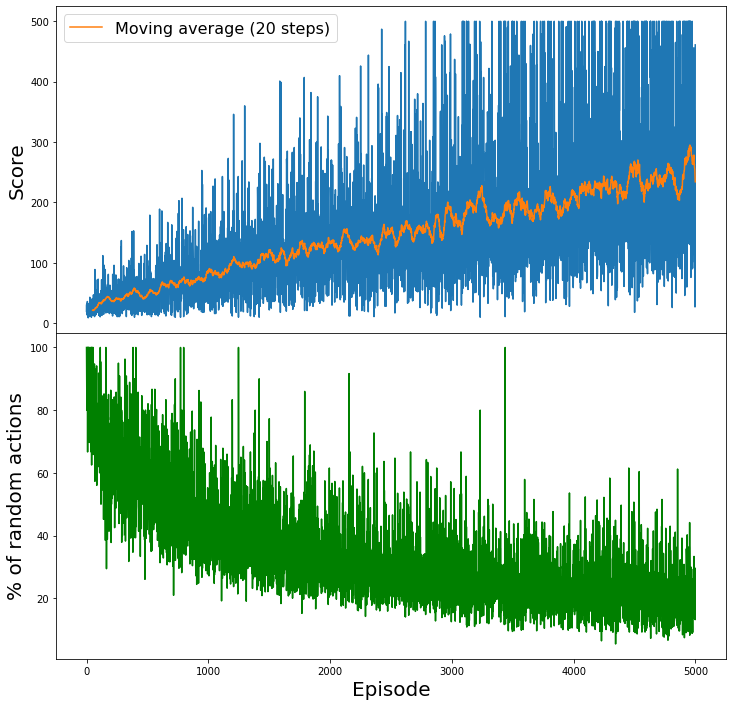

In [45]:
from matplotlib import pyplot as plt

figure = plt.figure()
fig, ax = plt.subplots(2, 1, figsize = (12,12), sharex=True)

moving_average = [np.array(score_List)[i:i+50].mean()  for i in range(len(score_List)-50)]
ax[0].plot(score_List)
ax[0].plot(range(50, len(moving_average) + 50),moving_average, label='Moving average (20 steps)')
ax[0].legend(fontsize=16)
ax[1].set_xlabel('Episode', fontsize=20)
ax[0].set_ylabel('Score', fontsize=20)
ax[1].plot(percent_new, color="green")
ax[1].set_ylabel('% of random actions', fontsize=20)
fig.subplots_adjust(hspace=0)
plt.show()

In [27]:
import pickle

def save_parameters(agent):
    save_param = {'scale': agent.scale, 'explore': agent.explore, 'full_memory': agent.full_memory}
    with open('agent_params.pkl', 'wb') as f:
        pickle.dump(save_param, f)

def restore_parameters():
    with open('agent_params.pkl', 'rb') as f:
        save_param = pickle.load(f)
        agent = Agent(scale=save_param['scale'], explore=save_param['explore'])
        agent.full_memory = save_param['full_memory']
    return agent

In [25]:
save_parameters(agent)

In [28]:
agent2 = restore_parameters()